# FFT example in Numpy and OpenCV

[Copy of this OpenCV tutorials page](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html)

### First, import modules

Note that OpenCV doesn't come with the Anaconda Python distribution. You have to install it separately:

```
conda install -c conda-forge opencv
```

On my Mac I got an error trying to import OpenCV with the `import cv2` command – some sort of conflict with libfreetype and libopencv_freetype. I was able to fix it by updating everything after install:

```
conda update --all
```

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

#### and load the sample image

In [2]:
img = cv2.imread('messi5.jpg',0)

## Fourier Transform in Numpy

First we will see how to find Fourier Transform using Numpy. Numpy has an FFT package to do this. `np.fft.fft2()` provides us the frequency transform which will be a complex array. Its first argument is the input image, which is grayscale. Second argument is optional which decides the size of output array. If it is greater than size of input image, input image is padded with zeros before calculation of FFT. If it is less than input image, input image will be cropped. If no arguments passed, Output array size will be same as input.

Now once you got the result, zero frequency component (DC component) will be at top left corner. If you want to bring it to center, you need to shift the result by $ \frac{N}{2} $ in both the directions. This is simply done by the function, `np.fft.fftshift()`. (It is more easier to analyze). Once you found the frequency transform, you can find the magnitude spectrum.

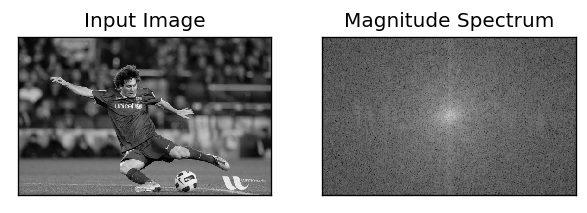

In [3]:
f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

# Changing the default dpi to make the figures bigger
plt.rcParams['figure.dpi'] = 120

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

See, You can see more whiter region at the center showing low frequency content is more.

So you found the frequency transform Now you can do some operations in frequency domain, like high pass filtering and reconstruct the image, ie find inverse DFT. For that you simply remove the low frequencies by masking with a rectangular window of size 60x60. Then apply the inverse shift using `np.fft.ifftshift()` so that DC component again come at the top-left corner. Then find inverse FFT using `np.ifft2()` function. The result, again, will be a complex number. You can take its absolute value.

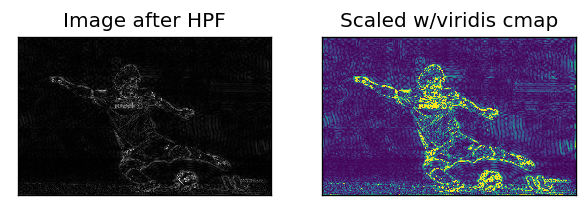

In [4]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plt.subplot(121),plt.imshow(img_back, cmap = 'gray')
plt.title('Image after HPF'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, vmax=40, cmap = 'viridis')
plt.title('Scaled w/viridis cmap'), plt.xticks([]), plt.yticks([])

plt.show()

The result shows High Pass Filtering is an edge detection operation. This is what we have seen in Image Gradients chapter. This also shows that most of the image data is present in the Low frequency region of the spectrum. Anyway we have seen how to find DFT, IDFT etc in Numpy. Now let’s see how to do it in OpenCV.

If you closely watch the result, especially the last image in viridis color, you can see some artifacts. It shows some ripple like structures there, and it is called ringing effects. It is caused by the rectangular window we used for masking. This mask is converted to sinc shape which causes this problem. So rectangular windows is not used for filtering. Better option is Gaussian Windows.

## Fourier Transform in OpenCV

OpenCV provides the functions `cv2.dft()` and `cv2.idft()` for this. It returns the same result as previous, but with two channels. First channel will have the real part of the result and second channel will have the imaginary part of the result. The input image should be converted to `np.float32` first. We will see how to do it.

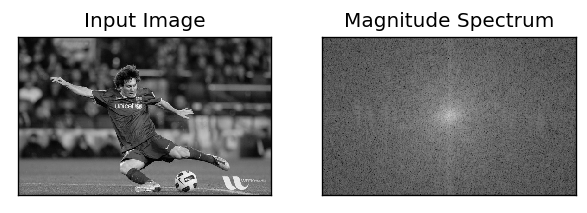

In [5]:
dft = cv2.dft(np.float32(img),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

magnitude_spectrum = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

*<font color=#2351A6>NOTE: You can also use cv2.cartToPolar() which returns both magnitude and phase in a single shot</font>*

So, now we have to do inverse DFT. In previous session, we created a HPF, this time we will see how to remove high frequency contents in the image, ie we apply LPF to image. It actually blurs the image. For this, we create a mask first with high value (1) at low frequencies, ie we pass the LF content, and 0 at HF region.

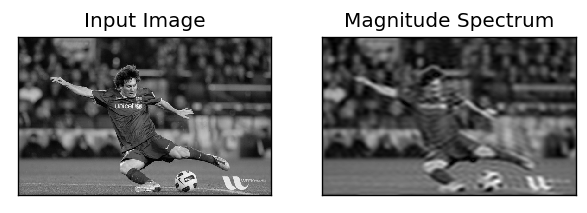

In [6]:
rows, cols = img.shape
crow,ccol = int(rows/2) , int(cols/2)

# create a mask first, center square is 1, remaining all zeros
mask = np.zeros((rows,cols,2),np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

# apply mask and inverse DFT
fshift = dft_shift*mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_back, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

*<font color=#2351A6>NOTE: As usual, OpenCV functions cv2.dft() and cv2.idft() are faster than Numpy counterparts. But Numpy functions are more user-friendly. For more details about performance issues, see below section.</font>*

### Why Laplacian is a High Pass Filter?

A similar question was asked in a forum. The question is, why Laplacian is a high pass filter? Why Sobel is a HPF? etc. And the first answer given to it was in terms of Fourier Transform. Just take the fourier transform of Laplacian for some higher size of FFT. Analyze it:

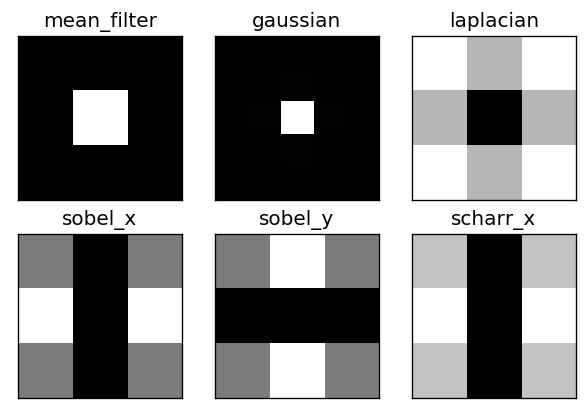

In [7]:
# simple averaging filter without scaling parameter
mean_filter = np.ones((3,3))

# creating a guassian filter
x = cv2.getGaussianKernel(5,10)
gaussian = x*x.T

# different edge detecting filters
# scharr in x-direction
scharr = np.array([[-3, 0, 3],
                   [-10,0,10],
                   [-3, 0, 3]])
# sobel in x direction
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# sobel in y direction
sobel_y = np.array([[-1,-2,-1],
                   [0, 0, 0],
                   [1, 2, 1]])
# laplacian
laplacian = np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

filters = [mean_filter, gaussian, laplacian, sobel_x, sobel_y, scharr]
filter_name = ['mean_filter', 'gaussian','laplacian', 'sobel_x', \
                'sobel_y', 'scharr_x']
fft_filters = [np.fft.fft2(x) for x in filters]
fft_shift = [np.fft.fftshift(y) for y in fft_filters]
mag_spectrum = [np.log(np.abs(z)+1) for z in fft_shift]

for i in range(6):
    plt.subplot(2,3,i+1),plt.imshow(mag_spectrum[i],cmap = 'gray')
    plt.title(filter_name[i]), plt.xticks([]), plt.yticks([])

plt.show()